In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [ ]:
import joblib
from pathlib import Path
import os
import cv2

from utils.render import render_w_pytorch3d
from utils.smpl_deformer.smpl_server import SMPLServer
from utils.io import load_frame_map_jsonl_restore
from preprocess.helpers.cameras import load_default_camdicts
from preprocess.helpers.video_utils import load_images

import numpy as np
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

In [ ]:
output_dir = "/scratch/izar/cizinsky/thesis/output/modric_vs_ribberi"
frame_path_path = f"{output_dir}/preprocess/frame_map.jsonl"
scene_root = f"{output_dir}/preprocess/"
h4d_results = load_frame_map_jsonl_restore(frame_path_path, scene_root=scene_root)

phalp_res_path = f"{output_dir}/phalp_v2/results/demo_images.pkl"
default_cam_dicts = load_default_camdicts(phalp_res_path)


img_path = os.path.join(scene_root, "images")
rgb_images = load_images(img_path)

In [ ]:
smpl_server = SMPLServer()
out = render_w_pytorch3d(
    default_cam_dicts,
    h4d_results,
    smpl_server,
    smpl_server.smpl.faces,
    zoom_scale=1
)

In [ ]:
fids = sorted(out.keys())
@interact(i=IntSlider(min=0, max=len(fids)-1, step=1, value=0))
def show(i=0):
    fid = fids[i]

    rend = out[fid]  # (H,W,4), RGBA, uint8
    smpl_rgb = rend[..., :3].astype(np.float32) / 255.0
    a = rend[..., 3:4].astype(np.float32) / 255.0   # (H,W,1)

    frame = rgb_images[fid].astype(np.float32) / 255.0
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    comp = smpl_rgb * a + frame * (0.8 - a)
        
    plt.figure(figsize=(10,6))
    plt.imshow(comp)
    plt.axis('off')

In [10]:
import torch
from gsplat import rasterization
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define Gaussians
means = torch.randn((100, 3), device=device)
quats = torch.randn((100, 4), device=device)
scales = torch.rand((100, 3), device=device) * 0.1
colors = torch.rand((100, 3), device=device)
opacities = torch.rand((100,), device=device)

# define cameras
viewmats = torch.eye(4, device=device).unsqueeze(0)
Ks = torch.tensor([
   [300., 0., 150.], [0., 300., 100.], [0., 0., 1.]], device=device).unsqueeze(0)
width, height = 300, 200

In [12]:
print(viewmats.shape, Ks.shape)

torch.Size([1, 4, 4]) torch.Size([1, 3, 3])


(-0.5, 299.5, 199.5, -0.5)

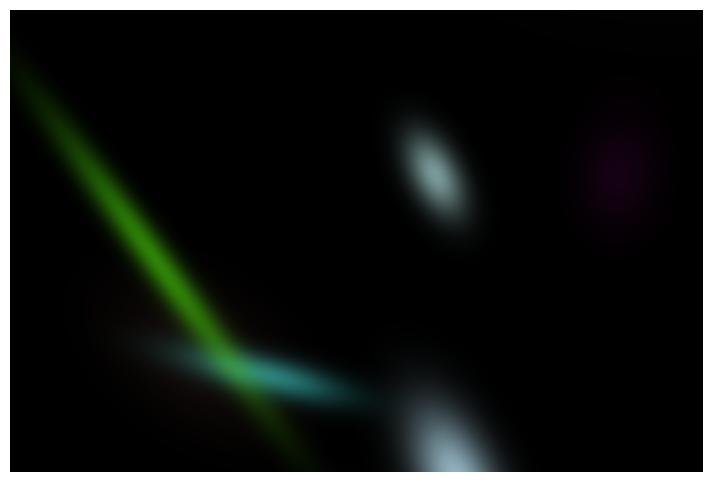

In [13]:
# render
colors, alphas, meta = rasterization(
   means, quats, scales, opacities, colors, viewmats, Ks, width, height, 
)

# visualize
plt.figure(figsize=(10,6))
plt.imshow(colors.squeeze().cpu().numpy())
plt.axis('off')

In [14]:
from hydra import initialize, compose
from training.run import Trainer, lbs_apply
from training.helpers.utils import init_logging

In [15]:
# Point to your config directory (relative to the notebook location)
config_path = "../configs"   # adjust if needed

# Initialize Hydra
with initialize(config_path=config_path, version_base=None):
    cfg = compose(config_name="train.yaml", overrides=["scene_name=modric_vs_ribberi"])

print("ℹ️ Initializing Trainer")
init_logging(cfg)
trainer = Trainer(cfg)
print("✅ Trainer initialized.\n")

ℹ️ Initializing Trainer
--- FYI: Running in debug mode, wandb logging is disabled.
--- FYI: using device cuda
--- FYI: Loaded cam_dicts from /scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/preprocess/cam_dicts.json, 87 frames
--- FYI: found 79 frames for tid=1
--- FYI: dataset has 79 samples and using batch size 1
--- FYI: experiment output dir: /scratch/izar/cizinsky/thesis/output/modric_vs_ribberi/training/dummy-jn7h99zc_jn7h99zc
--- FYI: training 16000 parameters
✅ Trainer initialized.



In [18]:
loader = trainer.loader
batch = next(iter(loader))

device, dtype = trainer.device, torch.float32

# Fetch data
image = batch["image"].squeeze(0).to(device)  # [3,H,W]
mask  = batch["mask"].squeeze(0).to(device)   # [H,W]
K  = batch["K"].squeeze(0).to(device)      # [3,3]
smpl_param = batch["smpl_param"].to(device)  # [1,86]
dev_height, dev_width = image.shape[-2:]

# Prepare gaussians
# - Means
out = trainer.smpl_server(smpl_param, absolute=False)
T_rel = out["smpl_tfs"][0]   # [24,4,4]
dev_means = lbs_apply(trainer.gaus.means_c, trainer.gaus.weights_c, T_rel)  # [M,3]
# dev_means[:, 0] *= -1.0
# dev_means[:, 1] *= -1.0
# dev_means[:, 2] *= -1.0

# - Quats
M = dev_means.shape[0]
dev_quats = torch.zeros(M, 4, device=device, dtype=dtype)
dev_quats[:, 0] = 1.0
# - Scales
dev_scales = trainer.gaus.scales().unsqueeze(1).expand(-1, 3).contiguous() # isotropic scales
# - Colours
dev_colors = trainer.gaus.colors.clamp(0, 1)
# - Opacity
dev_opacity = trainer.gaus.opacity()

# Define cameras
dev_viewmats = torch.eye(4, device=device, dtype=dtype).unsqueeze(0)   # [1,4,4]
dev_Ks = K.to(device, dtype).unsqueeze(0).contiguous()                  # [1,3,3]

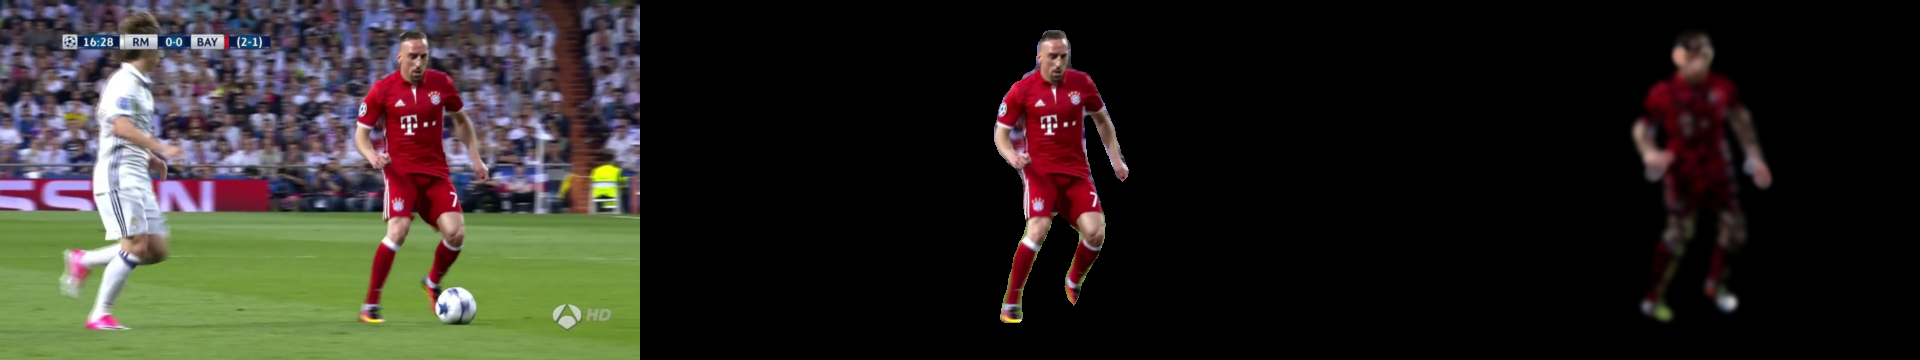

In [19]:
# Render
colors, alphas, meta = rasterization(
   dev_means, dev_quats, dev_scales, dev_opacity, dev_colors, dev_viewmats, dev_Ks, dev_width, dev_height
)
rgb_pred = colors.squeeze().permute(2, 0, 1).detach()

# Ensure all are 3×H×W tensors
H, W = image.shape[-2:]
mask3 = mask.expand_as(image)  # [3,H,W]
masked_img = image * mask3

# Stack [3, H, W] tensors into [3, H, 3*W]
comparison = torch.cat([image, masked_img, rgb_pred], dim=-1)

# Convert to uint8 for saving
img = (comparison.permute(1,2,0).cpu().numpy().clip(0,1) * 255).astype(np.uint8)
Image.fromarray(img)